In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import RMSE

In [6]:
PATH = os.path.abspath('..')

In [86]:
bs = 16
sz = 32

In [87]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)

In [88]:
df.head()

,objID,oh_p50
0,1237648704043942146,8.882136
1,1237667292122513532,8.951163
2,1237665441525596194,8.823326
3,1237674289683300721,9.104471
4,1237663716556341422,9.014245


# Set up DataBunch object

In [103]:
src = (ImageItemList.from_df(df, path=PATH, folder='train', suffix='.jpg', cols='objID')
                .random_split_by_pct(0.2, seed=1234)
                .label_from_df(cols='oh_p50')
                .add_test_folder(test_folder='test'))

In [104]:
data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize())

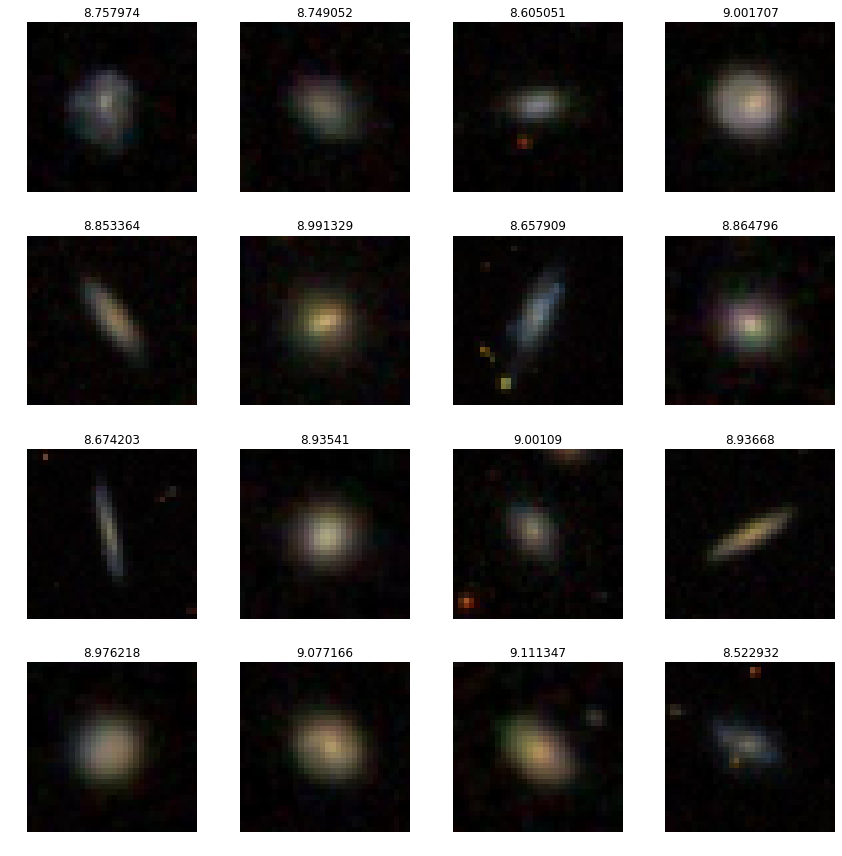

In [106]:
data.show_batch(4, figsize=(12, 12))

# Set up simple convnet

In [92]:
defaults.device = torch.device('cpu')

In [93]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                  # pretrained kw is hardcoded into create_cnn
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [97]:
#learn = create_cnn(data, arch=SimpleCNN, pretrained=False, metrics=[RMSE])
learn = create_cnn(data, arch=models.resnet18, pretrained=False, metrics=[RMSE])

# Find learning rate and train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


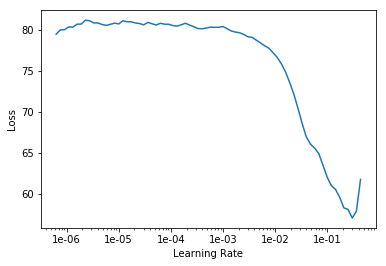

In [98]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [99]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,RMSE


TypeError: object() takes no parameters

# Do image resizing

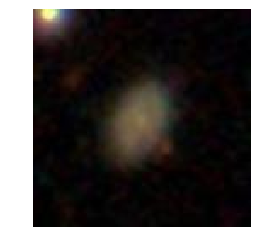

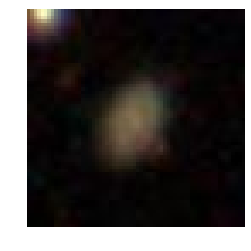

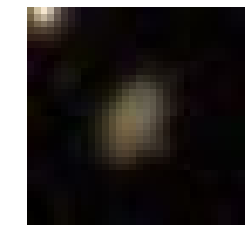

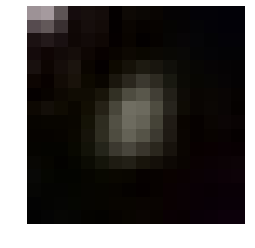

In [6]:
arch = SimpleCNN()
bs = 4

for sz in [128, 64, 32, 16]:

    # update transformations and ImageClassiferData
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                        suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)
    
    # caches the resized images in PATH/tmp for future use
    data = data.resize(sz)
    
    # show image
    plt.imshow(data.trn_ds.get_x(42))
    plt.axis('off')
    plt.show();

# Train on $16 \times 16$ images

In [45]:
sz = 16

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((8,8)))                     # note the adaptive pooling layer
        self.fc = nn.Linear(32*8*8, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [46]:
arch = SimpleCNN()

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

data.resize(sz)

learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

 84%|████████▍ | 67/80 [00:00<00:00, 86.98it/s, loss=20.6]


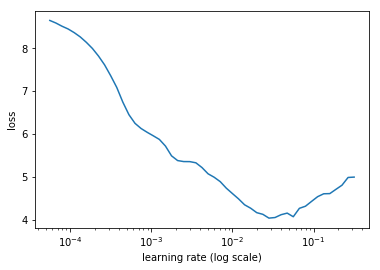

In [47]:
learn.lr_find()
learn.sched.plot()

epoch      trn_loss   val_loss                             
    0      0.86941    0.827103  
    1      0.453537   0.475533                             



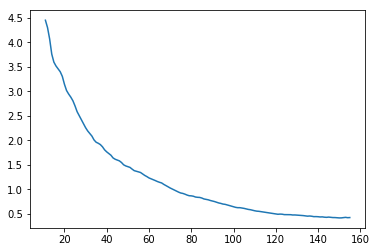

In [48]:
lr = 1e-3

learn.fit(lr, n_cycle=2)

learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.229753   0.124502  
    1      0.220737   0.386582                             



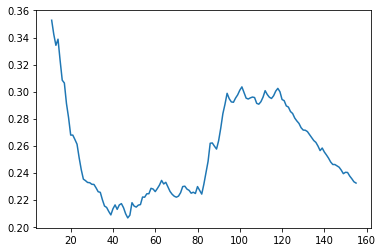

In [49]:
lr = 3e-4

learn.fit(lr, n_cycle=2)

learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.161718   0.120248  
    1      0.155547   0.114149                              
    2      0.146191   0.113359                              
    3      0.157153   0.113334                             
    4      0.157665   0.120486                             
    5      0.147085   0.142036                             
    6      0.138113   0.118423                             



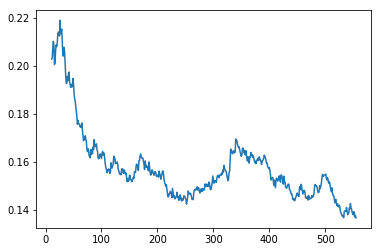

In [50]:
lr = 1e-4

learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

# Test the $16 \times 16$ images

In [51]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)
df_test = pd.read_csv(f'{PATH}/catalogs/test.csv', index_col=0)
Z_true = df_test.loc[test_names].values

In [52]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.146 dex                        


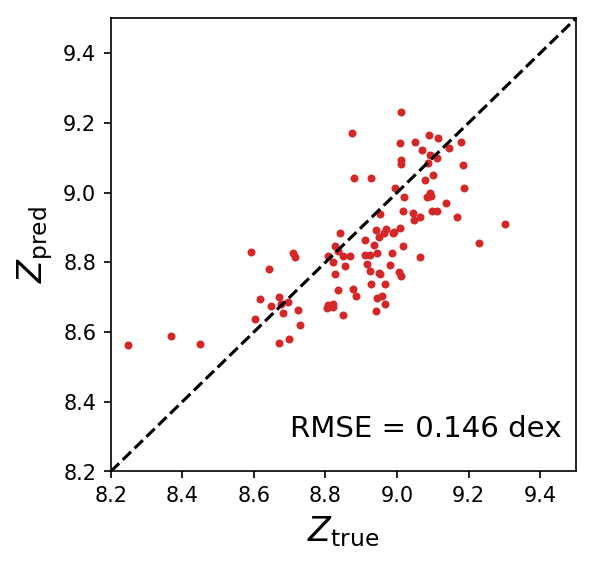

In [53]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.7, 8.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

In [54]:
def load_image(idx, df, sz=sz, ax=None, annotate=True):
    """Helper function to display and annotate image"""
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    Z_pred, Z_true = df.iloc[idx]
    name = df.index[idx]
    
    # get image
    image = plt.imread(f'{PATH}/tmp/{sz}/test/{name}.jpg')
    ax.imshow(image)
    ax.axis('off')
    
    # label
    if annotate:
        fontdict = dict(color='white', size=18)
        #ax.text(0.5, 0.9, f'{name}', fontdict=fontdict, transform=ax.transAxes, ha='center', va='bottom')
        ax.text(0.95, 0.125, r'$Z_{\rm true}$' + f' = {Z_true:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')
        ax.text(0.95, 0.025, r'$Z_{\rm pred}$' + f' = {Z_pred:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')

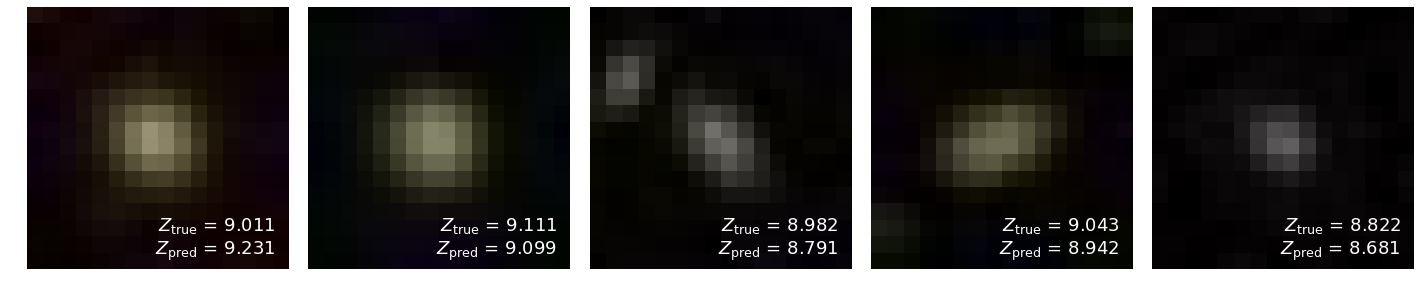

In [55]:
# show results
res = pd.DataFrame({'Z_pred': Z_pred.flatten(), 'Z_true': Z_true.flatten()}, index=test_names)

# random selection of five galaxies
rand = res.sample(frac=1., random_state=256)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)

# Same thing but with $64 \times 64$ images

In [56]:
sz = 64
arch = SimpleCNN()

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

data.resize(sz)

learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

 78%|███████▊  | 62/80 [00:01<00:00, 39.50it/s, loss=14.3]


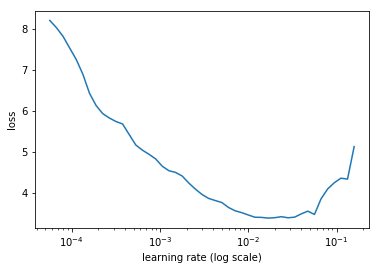

In [57]:
learn.lr_find()
learn.sched.plot()

epoch      trn_loss   val_loss                            
    0      1.032563   1.217332  
    1      0.607396   0.685513                             



epoch      trn_loss   val_loss                             
    0      0.384318   0.485564  
    1      0.30959    0.214205                             



epoch      trn_loss   val_loss                             
    0      0.279247   0.166468  
    1      0.247428   0.144502                             
    2      0.254157   0.150522                             
    3      0.28705    0.186392                             
    4      0.279344   0.187913                             
    5      0.255616   0.147724                             
    6      0.244111   0.139071                             



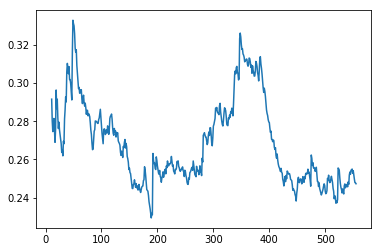

In [58]:
learn.fit(1e-3, 2)
learn.fit(3e-4, 2)
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [59]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.184 dex                        


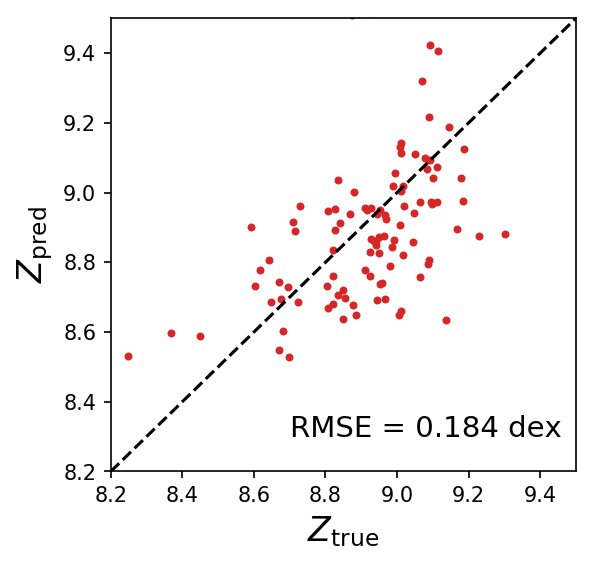

In [60]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.7, 8.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

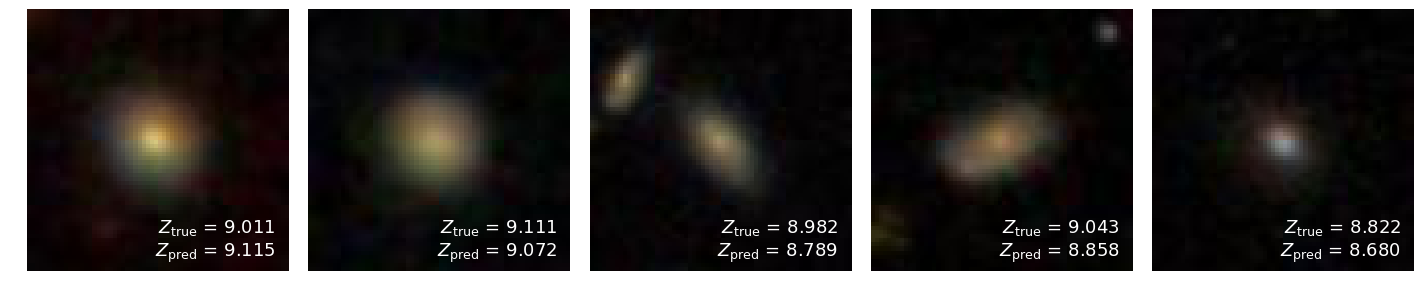

In [61]:
# show results
res = pd.DataFrame({'Z_pred': Z_pred.flatten(), 'Z_true': Z_true.flatten()}, index=test_names)

# random selection of five galaxies
rand = res.sample(frac=1., random_state=256)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax, sz=sz)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)

This actually performs **worse** than the $16 \times 16$ images. Why? Probably because we are still in the underfitting regime -- the model has not yet been able to leverage all data. It's also worth mentioning that the data set is so small, with 320 training examples, that simply "regressing to the mean" (or only predicting the mean) is enough to achieve 0.20 dex accuracy.

As the models begin to *overfit* the data, then we can start to see the power of deeper networks and larger data sets.